  # Introduction

  This is a copy of the  example given on the Deeptime documentation website [here](https://deeptime-ml.github.io/latest/notebooks/examples/ala2-example.html).  Run this example first before trying any of the experimental code to make sure everting is working as it should!

In [2]:
from copy import deepcopy
import os
from click import progressbar

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  

from deeptime.util.types import to_dataset
from tqdm.notebook import tqdm  # progress bar
from deeptime.decomposition.deep import VAMPNet
from torch.utils.data import DataLoader




 # Hyperparameters

  30% validation split
  10000 batch size
  lagtime of 1
  Network architecture:
  Input layer is 60, corresponding to the number of atomic coordinates of the heavy atoms of alanine tripeptide
  There are 20 heavy atoms in alanine tripeptide, and each has an X, Y, and Z coordinate, giving 60 data points total.
  There follows an intermediate layer 60x60, then another 60x100
  There are then four hidden layers shaped 100x100
  Then a layer 100x60
  And finally a layer 60x6, giving 6 output states.
  Alanine tripeptide's ramachandran plot shows 6 distinct metastable states.
  See validation loss below the training/validation graph


  try changing learning rate
  add horozontal line to validation chart to show max score (n_states)

In [3]:
assert torch.cuda.is_available(), "Need a GPU with CUDA" 
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True



  ## Globals

In [4]:
data_dir = "/home/matthewb/online_vampnets/data"
data_dir = "/home/mbowley/ANI-Peptides/outputs/old_aaa_amber_4us/trajectory_split_162517_190322"
lag_time = 1




In [5]:
file_coords = os.path.join(data_dir, "coords_archive.npz")
with np.load(file_coords) as fh:
    data_coords = fh["arr_0"].astype(np.float32)

file_dihedral = os.path.join(data_dir, "dihedrals_archive.npz")
with np.load(file_dihedral) as fh:
    data_dihedral = fh["arr_0"].astype(np.float32)

print(data_coords.shape)
print(data_dihedral.shape)



(3918948, 60)
(3918948, 2, 3)


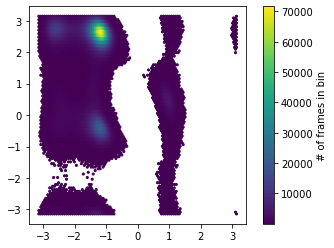

In [6]:
f, ax = plt.subplots(1, 1)

x = data_dihedral[:, 0, :].flat
y = data_dihedral[:, 1, :].flat
hb = ax.hexbin(x, y, mincnt=5)
ax.set_aspect('equal')
cb = f.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')



  The following function splits up the trajectory `data_coords` into pairs (X_t, X_t+lagtime) and then puts all pairs from the trajectory into a single generator.

  So for lagtime = 1:
   - The trajectory data is shape (x, 60), x is the length of the traj (sampled every ps) and 60 being the number of coordinates
   - The dataset will have length x-1, each item will be a tuple of length 2 (Xt, Xt+1), and each tuple item will have length 60


In [7]:
print(data_coords.shape)
dataset = to_dataset(data=data_coords, lagtime=1)
print(len(dataset), len(dataset[0]), len(dataset[0][0]))



(3918948, 60)
3918947 2 60


In [96]:
n_coords = data_coords.shape[1]
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
n_output_states = 2
n_epochs = 4



In [97]:
lobe = nn.Sequential(
    nn.BatchNorm1d(data_coords.shape[1]),
    nn.Linear(data_coords.shape[1], n_coords), nn.ELU(),
    nn.Linear(n_coords, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, 100), nn.ELU(),
    nn.Linear(100, n_coords), nn.ELU(),
    nn.Linear(n_coords, n_output_states),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe_timelagged = deepcopy(lobe).to(device=device)
lobe = lobe.to(device=device)
print(lobe)



Sequential(
  (0): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=60, out_features=60, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=60, out_features=100, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ELU(alpha=1.0)
  (13): Linear(in_features=100, out_features=60, bias=True)
  (14): ELU(alpha=1.0)
  (15): Linear(in_features=60, out_features=2, bias=True)
  (16): Softmax(dim=1)
)


In [98]:
vampnet = VAMPNet(lobe=lobe, lobe_timelagged=lobe_timelagged, learning_rate=5e-3, device=device)



In [99]:
loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)



In [100]:
model = vampnet.fit(loader_train, n_epochs,
                    validation_loader=loader_val, progress=tqdm).fetch_model()



VAMPNet epoch:   0%|          | 0/4 [00:00<?, ?it/s]

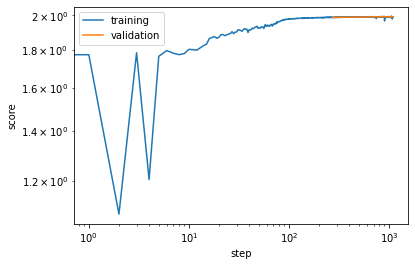

In [101]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend()



In [107]:
validation_score = max(vampnet.train_scores[:, 1])
print(f"Number of epochs: {n_epochs}")
print(f"Number of output states: {n_output_states}")
print(f"Final validation score: {validation_score}")
print(f"Validation loss: {100*(n_output_states - validation_score):.3f}%")

Number of epochs: 4
Number of output states: 2
Final validation score: 1.9936928749084473
Validation loss: 0.631%


In [103]:
state_probabilities = model.transform(data_coords)
print(state_probabilities.shape)
print(data_coords.shape)
print(data_dihedral.shape)
x = data_dihedral.reshape(len(data_dihedral), -1).shape

(3918948, 2)
(3918948, 60)
(3918948, 2, 3)


(3918948, 2)
(3918948, 2, 3)


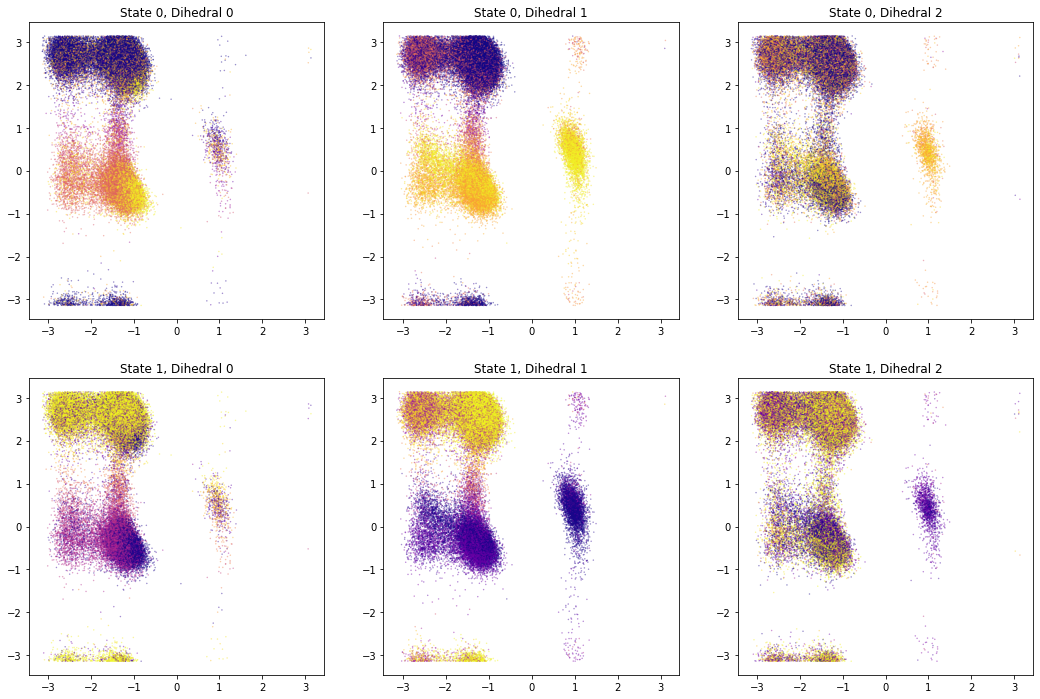

In [104]:
state_probabilities = model.transform(data_coords)
# state_probabilities = np.vstack([state_probabilities])
print(state_probabilities.shape)
print(data_dihedral.shape)
f, axes = plt.subplots(n_output_states, 3, figsize=(18, (18//3*n_output_states)))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(
        data_dihedral[:, 0, i%3][::50], 
        data_dihedral[:, 1, i%3][::50], 
        c=state_probabilities[:, i//3][::50],
        cmap="plasma",
        s=.2,
        alpha=.5
    )
    ax.set_title(f'State {i//3}, Dihedral {i%3}')



In [108]:
state_probabilities = model.transform(data_coords)
for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0),
                                      np.max(state_probabilities, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")



State 1: [0.011390626430511475, 0.9512696862220764]
State 2: [0.048730384558439255, 0.9886094331741333]


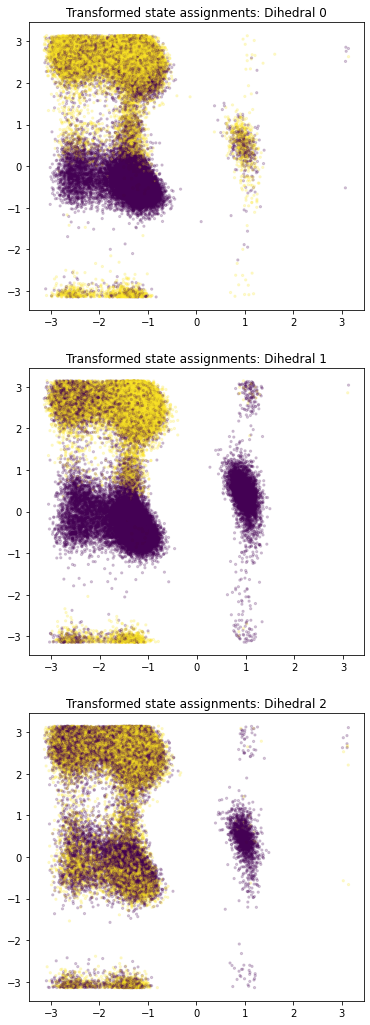

In [109]:
assignments = state_probabilities.argmax(1)
f, axes = plt.subplots(3, 1, figsize=(6, 18))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(*data_dihedral[:, :, i][::50].T, c=assignments[::50], s=5, alpha=.2)
    ax.set_title(f'Transformed state assignments: Dihedral {i}')





In [110]:
from deeptime.decomposition import VAMP

vamp_estimator = VAMP(lagtime=1, observable_transform=model)
vamp = vamp_estimator.fit(data_coords).fetch_model()
print(f"VAMP-2 score under lag 10: s = {vamp.score(2).round(2)}")

VAMP-2 score under lag 10: s = 1.99


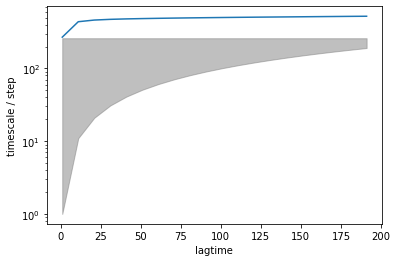

In [113]:
lagtimes = np.arange(1, 201, 10, dtype=np.int32)
timescales = []
for lag in lagtimes:
    ts = VAMP(lagtime=lag, observable_transform=model).fit(data_coords).fetch_model().timescales(k=5)
    timescales.append(ts)

f, ax = plt.subplots(1, 1)
ax.semilogy(lagtimes, timescales)
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale / step')
ax.fill_between(lagtimes, ax.get_ylim()[0]*np.ones(len(lagtimes)), lagtimes, alpha=0.5, color='grey')

In [ ]:
vamp_estimator = VAMP(lagtime=1, observable_transform=model)
vamp = vamp_estimator.fit(data_coords).fetch_model()

validator = vamp_estimator.chapman_kolmogorov_validator(mlags=20)
cktest = validator.fit(data_coords, n_jobs=1).fetch_model()

In [ ]:
n_states = len(vamp.singular_values)

tau = cktest.lagtimes[1]
steps = len(cktest.lagtimes)
fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True, constrained_layout=True)
for i in range(n_states):
    for j in range(n_states):
        pred = ax[i][j].plot(cktest.lagtimes, cktest.predictions[:, i, j], color='b')
        est = ax[i][j].plot(cktest.lagtimes, cktest.estimates[:, i, j], color='r', linestyle='--')
        ax[i][j].set_title(str(i+1)+ '->' +str(j+1),
                                       fontsize='small')
ax[0][0].set_ylim((-0.1,1.1))
ax[0][0].set_xlim((0, steps*tau))
ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 3)));
fig.legend([pred[0], est[0]], ["Predictions", "Estimates"], 'lower center', ncol=2,
           bbox_to_anchor=(0.5, -0.1))